In [6]:
import numpy as np
import matplotlib.pyplot as plt

def aperiodic_first_por(k:int,factors:list, omega:list):
    real_magnitude_db   = np.zeros_like(omega, dtype=float)
    approx_magnitude_db = np.zeros_like(omega, dtype=float)
    angel               = np.zeros_like(omega, dtype=float)

    for (T) in factors:
        factor_magnitude = k / np.sqrt(1 + (T*omega)**2)
        factor_magnitude_db =   20 * np.log10(factor_magnitude)

        omega_break = 1.0 / T
        below_break = (omega < omega_break)
        above_break = ~below_break

        factor_approx_db = np.zeros_like(omega)

        factor_approx_db[below_break] = 20 * np.log10(k)

        factor_approx_db[above_break] = 20 * np.log10(k) - 20 * np.log10(T*omega[above_break])

        real_magnitude_db   += factor_magnitude_db
        approx_magnitude_db += factor_approx_db
        angel               += -np.arctan(T*omega)

    return np.array([real_magnitude_db, approx_magnitude_db,angel])

def forsiruyochie_first_por(k:int,factors:list, omega:list):
    real_magnitude_db   = np.zeros_like(omega, dtype=float)
    approx_magnitude_db = np.zeros_like(omega, dtype=float)
    angel               = np.zeros_like(omega, dtype=float)

    for (T) in factors:
        factor_magnitude    = k * np.sqrt(1 + (T*omega)**2)
        factor_magnitude_db = 20 * np.log10(factor_magnitude)

        omega_break = 1.0 / T
        below_break = (omega < omega_break)
        above_break = ~below_break

        factor_approx_db = np.zeros_like(omega)
        factor_approx_db[below_break] = 20 * np.log10(k)

        factor_approx_db[above_break] = 20 * np.log10(k) + 20 * np.log10(T*omega[above_break])

        real_magnitude_db   += factor_magnitude_db
        approx_magnitude_db += factor_approx_db
        angel               += np.arctan(T*omega)

    return np.array([real_magnitude_db, approx_magnitude_db,angel])

def integriruyouchie(k:int,factors:list, omega:list):
    real_magnitude_db   = np.zeros_like(omega, dtype=float)
    approx_magnitude_db = np.zeros_like(omega, dtype=float)
    angel               = np.zeros_like(omega, dtype=float)

    for (T) in factors:
        factor_magnitude    = k / (omega*T)
        factor_magnitude_db = 20 * np.log10(factor_magnitude)

        factor_approx_db = factor_magnitude_db

        real_magnitude_db   += factor_magnitude_db
        approx_magnitude_db += factor_approx_db
        angel               += - np.pi / 2

    return np.array([real_magnitude_db, approx_magnitude_db,angel])

def colebatelbnoe(k: int, factors: list, omega: list, psi: int):
    real_magnitude_db   = np.zeros_like(omega, dtype=float)
    approx_magnitude_db = np.zeros_like(omega, dtype=float)
    angel               = np.zeros_like(omega, dtype=float)

    for _, T in enumerate(factors):  # Убираем лишние скобки вокруг T
        factor_magnitude = k / np.sqrt(((1-T**2*omega**2)**2 + (2*psi*T*omega)**2))
        factor_magnitude_db = 20 * np.log10(factor_magnitude)

        omega_break = 1.0 / T
        below_break = (omega < omega_break)
        above_break = ~below_break

        factor_approx_db = np.zeros_like(omega)
        factor_approx_db[below_break] = 20 * np.log10(k)
        factor_approx_db[above_break] = 20 * np.log10(k) - 20 * np.log10(T**2*omega[above_break]**2)

        angel[below_break]  += -np.arctan((2*psi*T*omega[below_break])/(1-T**2*omega[below_break]))
        angel[above_break]  += -np.arctan((2*psi*T*omega[above_break])/(1-T**2*omega[above_break])) - np.pi
        real_magnitude_db   += factor_magnitude_db
        approx_magnitude_db += factor_approx_db

    return np.array([real_magnitude_db, approx_magnitude_db,angel])

def differenciruchee(k: int, factors: list, omega: list):
    real_magnitude_db   = np.zeros_like(omega, dtype=float)
    approx_magnitude_db = np.zeros_like(omega, dtype=float)
    angel               = np.zeros_like(omega, dtype=float)

    for _, T in enumerate(factors):  # Убираем лишние скобки вокруг T
        factor_magnitude = k * omega
        factor_magnitude_db = 20 * np.log10(factor_magnitude)

        omega_break = 1.0 / T
        below_break = (omega < omega_break)
        above_break = ~below_break

        factor_approx_db = np.zeros_like(omega) # not property work
        factor_approx_db[below_break] = 20 * np.log10(k)# not property work
        factor_approx_db[above_break] = 20 * np.log10(k) - 20 * np.log10(T**2*omega[above_break]**2)# not property work

        angel[below_break]  += np.pi / 2
        angel[above_break]  += np.pi / 2
        real_magnitude_db   += factor_magnitude_db
        approx_magnitude_db += factor_approx_db

    return np.array([real_magnitude_db, approx_magnitude_db,angel])


W(p) = ((0.1p+1)*((5p+1)^2)) / (49*(p^2)*(0.04p^2 +0.04p +1))

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, bode
start_log = -2
end_log   = 2
separates = 1000
psi       = 0.1

omega = np.logspace(start_log, end_log, separates)  # от 0.01 до 100 рад/с

# Типовые звенья:
# - (0.1p+1): угол частоты w_z = 1/0.1 = 10 рад/с
# - (5p+1)^2: дважды одно и то же звено с w1=1/5=0.2 рад/с
# - 7^2*p^2 в знаменателе: это -40 дБ/декаду наклон после низких частот
# - (0.04p^2 +0.2p +1) примерно колебательное звено с ω_n = 5 рад/с, ζ=0.1

# Построим асимптотическую ЛАЧХ:
# L_omega_as = (    colebatelbnoe          (k=1, factors=([0.2]),omega=omega, psi=psi)
#               + 2*forsiruyochie_first_por(k=1, factors=([5]),  omega=omega)
#               +   forsiruyochie_first_por(k=1, factors=([0.1]),omega=omega)
#               + 2*integriruyouchie       (k=1, factors=([7]),  omega=omega)
#               )
L_omega_as =  colebatelbnoe          (k=1, factors=([0.2]),omega=omega, psi=psi)+ \
              forsiruyochie_first_por(k=1, factors=([5,5,0.1]),  omega=omega)+ \
              integriruyouchie       (k=1, factors=([7,7]),  omega=omega)


# plt.figure(figsize=(12, 12))

# # ЛАЧХ
# plt.subplot(2,1,1)
# plt.semilogx(omega, colebatelbnoe(k=1, factors=([0.2]),omega=omega, psi=psi)[0], '--', label='Колебательные ЛАЧХ',linewidth=0.5)
# plt.semilogx(omega, forsiruyochie_first_por(k=1, factors=([5,5,0.1]),  omega=omega)[0], '--', label='Форсирующые ЛАЧХ',linewidth=0.5)
# plt.semilogx(omega, integriruyouchie       (k=1, factors=([7,7]),  omega=omega)[0], '--', label='Интегрирующые ЛАЧХ',linewidth=0.5)
# plt.semilogx(omega, L_omega_as[0], label='Сумма ЛАЧХ')
# plt.semilogx(omega, L_omega_as[1], label='Сумма  апроксимирующей ЛАЧХ')
# plt.title("ЛАЧХ")
# plt.xlabel('ω, рад/с')
# plt.ylabel('Амплитуда, дБ')
# plt.grid(True)
# plt.legend()

# # # ЛФЧХ
# plt.subplot(2,1,2)
# plt.semilogx(omega, colebatelbnoe(k=1, factors=([0.2]),omega=omega, psi=psi)[2], '--', label='Колебательные ЛфЧХ',linewidth=0.7)
# plt.semilogx(omega, forsiruyochie_first_por(k=1, factors=([5,5,0.1]),  omega=omega)[2], '--', label='Форсирующие ЛфЧХ',linewidth=0.7)
# plt.semilogx(omega, integriruyouchie       (k=1, factors=([7,7]),  omega=omega)[2], '--', label='Интегрирующие ЛфЧХ',linewidth=0.7)

# plt.semilogx(omega, L_omega_as[2], label='Сумма ЛФЧХ')
# plt.title("ЛФЧХ")
# plt.xlabel('ω, рад/с')
# plt.ylabel('Фаза, рад')
# plt.grid(True)
# plt.legend()

# plt.tight_layout()
# plt.show()


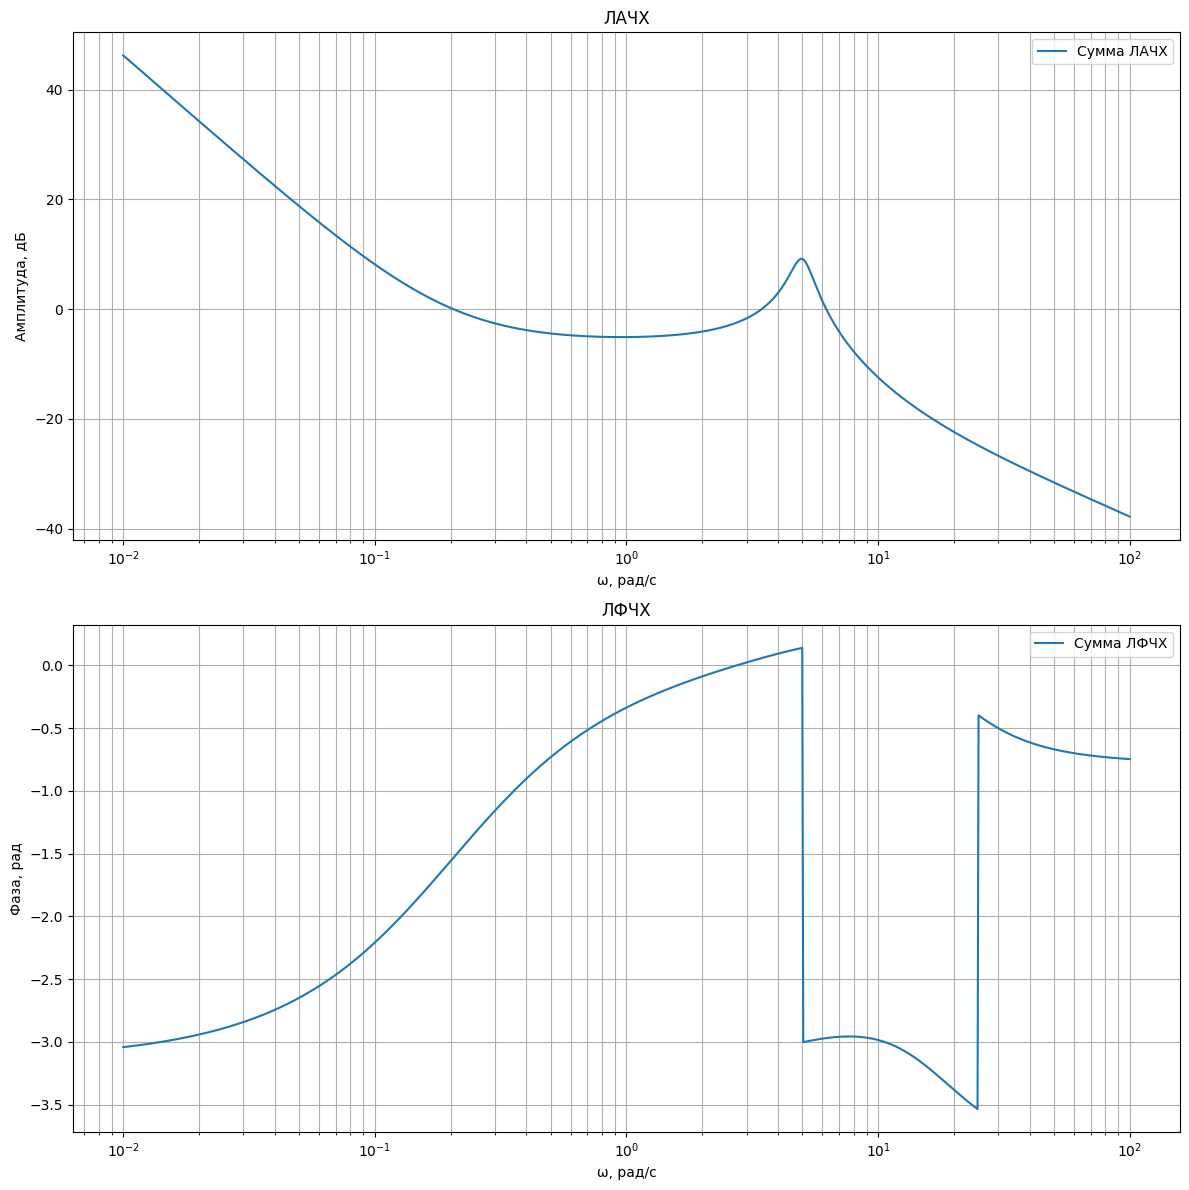

In [8]:
plt.figure(figsize=(12, 12))
# ЛАЧХ
plt.subplot(2,1,1)
# plt.semilogx(omega, colebatelbnoe(k=1, factors=([0.2]),omega=omega, psi=psi)[0], '--', label='Колебательные ЛАЧХ',linewidth=0.5)
# plt.semilogx(omega, forsiruyochie_first_por(k=1, factors=([5,5,0.1]),  omega=omega)[0], '--', label='Форсирующые ЛАЧХ',linewidth=0.5)
# plt.semilogx(omega, integriruyouchie       (k=1, factors=([7,7]),  omega=omega)[0], '--', label='Интегрирующые ЛАЧХ',linewidth=0.5)
plt.semilogx(omega, L_omega_as[0], label='Сумма ЛАЧХ')

# plt.semilogx(omega, L_omega_as[1], label='Сумма  апроксимирующей ЛАЧХ')
plt.title("ЛАЧХ")
plt.xlabel('ω, рад/с')
plt.ylabel('Амплитуда, дБ')
plt.grid(True, which='both')
plt.legend()

# # ЛФЧХ
plt.subplot(2,1,2)
# plt.semilogx(omega, colebatelbnoe(k=1, factors=([0.2]),omega=omega, psi=psi)[2], '--', label='Колебательные ЛфЧХ',linewidth=0.7)
# plt.semilogx(omega, forsiruyochie_first_por(k=1, factors=([5,5,0.1]),  omega=omega)[2], '--', label='Форсирующие ЛфЧХ',linewidth=0.7)
# plt.semilogx(omega, integriruyouchie       (k=1, factors=([7,7]),  omega=omega)[2], '--', label='Интегрирующие ЛфЧХ',linewidth=0.7)

plt.semilogx(omega, L_omega_as[2], label='Сумма ЛФЧХ')
plt.title("ЛФЧХ")
plt.xlabel('ω, рад/с')
plt.ylabel('Фаза, рад')
plt.grid(True, which='both')
plt.legend()

plt.tight_layout()
plt.show()


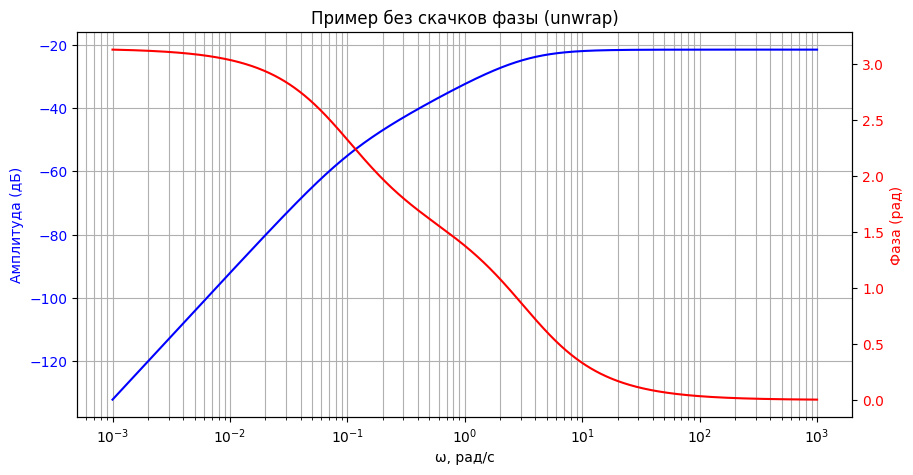

In [26]:
import numpy as np
import matplotlib.pyplot as plt

start_log = -3
end_log   = 3
separates = 1000
omega = np.logspace(start_log, end_log, separates)

# Предположим, что каждое из ваших звеньев возвращает
# ( real_magnitude_db, approx_magnitude_db, phase )
# и все они формы (N,) – то есть по одной кривой на «выход».

# Собираем «сумму» по дБ и по фазе:
total_real_mag_db   = np.zeros_like(omega)
total_approx_mag_db = np.zeros_like(omega)
total_phase         = np.zeros_like(omega)

# Пример: aperiodic_first_por(k=1, factors=[10,0.3], omega=omega) и т.д.
real_mag_1, approx_mag_1, phase_1 = aperiodic_first_por(k=1, factors=[10,0.3], omega=omega)
real_mag_2, approx_mag_2, phase_2 = differenciruchee(k=0.5, factors=[1,1], omega=omega)
# ... и другие звенья при необходимости ...

# Складываем
total_real_mag_db   += real_mag_1   + real_mag_2
total_approx_mag_db += approx_mag_1 + approx_mag_2
total_phase         += phase_1      + phase_2

# В самом конце разворачиваем фазу
total_phase_unwrapped = np.unwrap(total_phase)

# Строим графики
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.semilogx(omega, total_real_mag_db, label='ЛАЧХ (дБ)', color='blue')
ax1.set_xlabel('ω, рад/с')
ax1.set_ylabel('Амплитуда (дБ)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, which='both')

ax2 = ax1.twinx()
ax2.semilogx(omega, total_phase_unwrapped, label='ЛФЧХ (рад)', color='red')
ax2.set_ylabel('Фаза (рад)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Пример без скачков фазы (unwrap)")
plt.show()


Точки перелома (в порядке возрастания):
  ω = 0.1,  |W| (дБ) = -41.170,  фаза (рад) = 2.228
  ω = 0.5635,  |W| (дБ) = -25.185,  фаза (рад) = 1.181
  ω = 1,  |W| (дБ) = -21.901,  фаза (рад) = 0.889
  ω = 3.333,  |W| (дБ) = -17.288,  фаза (рад) = 0.042
  ω = 4.436,  |W| (дБ) = -17.392,  фаза (рад) = -0.211


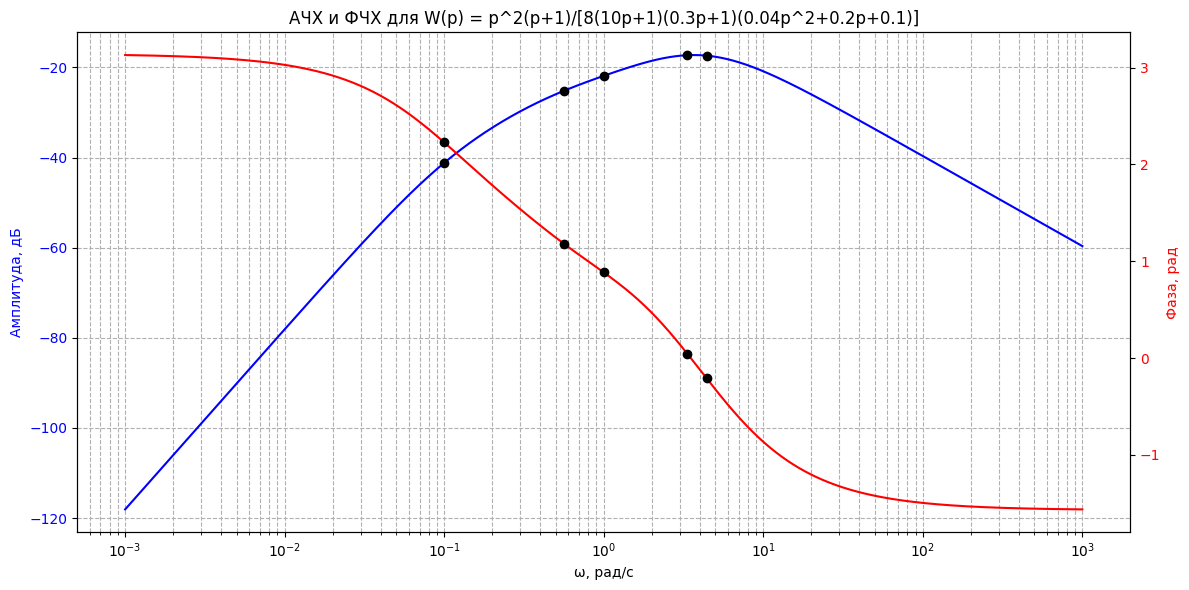

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Исходные данные ---
omega = np.logspace(-3, 3, 1000)      # Массив частот от 10^-3 до 10^3
jomega = 1j * omega                   # p = j*ω

# Передаточная функция W(p) = p^2*(p+1) / [8(10p+1)(0.3p+1)(0.04p^2+0.2p+0.1)]
num = jomega**2 * (jomega + 1)
den = 8 * (10*jomega + 1) * (0.3*jomega + 1) * (0.04*jomega**2 + 0.2*jomega + 0.1)
W = num / den

# ЛАЧХ (в дБ) и ЛФЧХ (развёрнутая фаза, чтобы убрать скачки)
mag_dB     = 20 * np.log10(np.abs(W))
phase_rad  = np.unwrap(np.angle(W))

# --- 2) Поиск «точек перелома» ---
#  - (10p+1) => p=-1/10 => частота перелома omega=0.1
#  - (0.3p+1) => p=-1/0.3 => omega=3.333...
#  - (p+1) => p=-1 => omega=1
#  - (0.04p^2 + 0.2p + 0.1) => находим корни и берём их модули
poly_coefs = [0.04, 0.2, 0.1]    # 0.04 p^2 + 0.2 p + 0.1 = 0
roots = np.roots(poly_coefs)     # Это список из двух корней
# Оставляем только отрицательные корни (ведь p=-alpha < 0),
# и берём их по модулю как частоты
real_poles = [abs(r) for r in roots if np.isreal(r) and r < 0]

# Собираем все «кандидаты» в список:
break_freqs = [
    0.1,        # (10p+1)
    1,          # (p+1)
    1/0.3,      # (0.3p+1) => 3.3333...
]
# Добавляем корни 2-го порядка
break_freqs += real_poles

# Сортируем по возрастанию
break_freqs = sorted(break_freqs)

# --- 3) Рисуем основной график ---
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xscale('log')
ax1.plot(omega, mag_dB, 'b', label='ЛАЧХ (дБ)')
ax1.set_xlabel('ω, рад/с')
ax1.set_ylabel('Амплитуда, дБ', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, which='both', ls='--')

ax2 = ax1.twinx()
ax2.plot(omega, phase_rad, 'r', label='ЛФЧХ (рад)')
ax2.set_ylabel('Фаза, рад', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('АЧХ и ФЧХ для W(p) = p^2(p+1)/[8(10p+1)(0.3p+1)(0.04p^2+0.2p+0.1)]')

# --- 4) На каждой точке перелома ставим «точку» и печатаем в консоль ---
print("Точки перелома (в порядке возрастания):")
for bf in break_freqs:
    # Ищем индекс в массиве omega, ближайший к bf
    idx = np.argmin(np.abs(omega - bf))
    # Считываем ЛАЧХ и ЛФЧХ в этой точке
    mag_val   = mag_dB[idx]
    phase_val = phase_rad[idx]

    # Выводим в консоль
    print(f"  ω = {bf:.4g},  |W| (дБ) = {mag_val:.3f},  фаза (рад) = {phase_val:.3f}")

    # Добавляем на график маркер
    ax1.plot(bf, mag_val, 'ko')      # чёрная точка на графике ЛАЧХ
    ax2.plot(bf, phase_val, 'ko')    # чёрная точка на графике ЛФЧХ

plt.tight_layout()
plt.show()


Точки перелома (в порядке возрастания):
  ω = 0.1,  |W| (дБ) = -41.170,  фаза (рад) = 2.228
  ω = 0.5635,  |W| (дБ) = -25.185,  фаза (рад) = 1.181
  ω = 1,  |W| (дБ) = -21.901,  фаза (рад) = 0.889
  ω = 3.333,  |W| (дБ) = -17.288,  фаза (рад) = 0.042
  ω = 4.436,  |W| (дБ) = -17.392,  фаза (рад) = -0.211


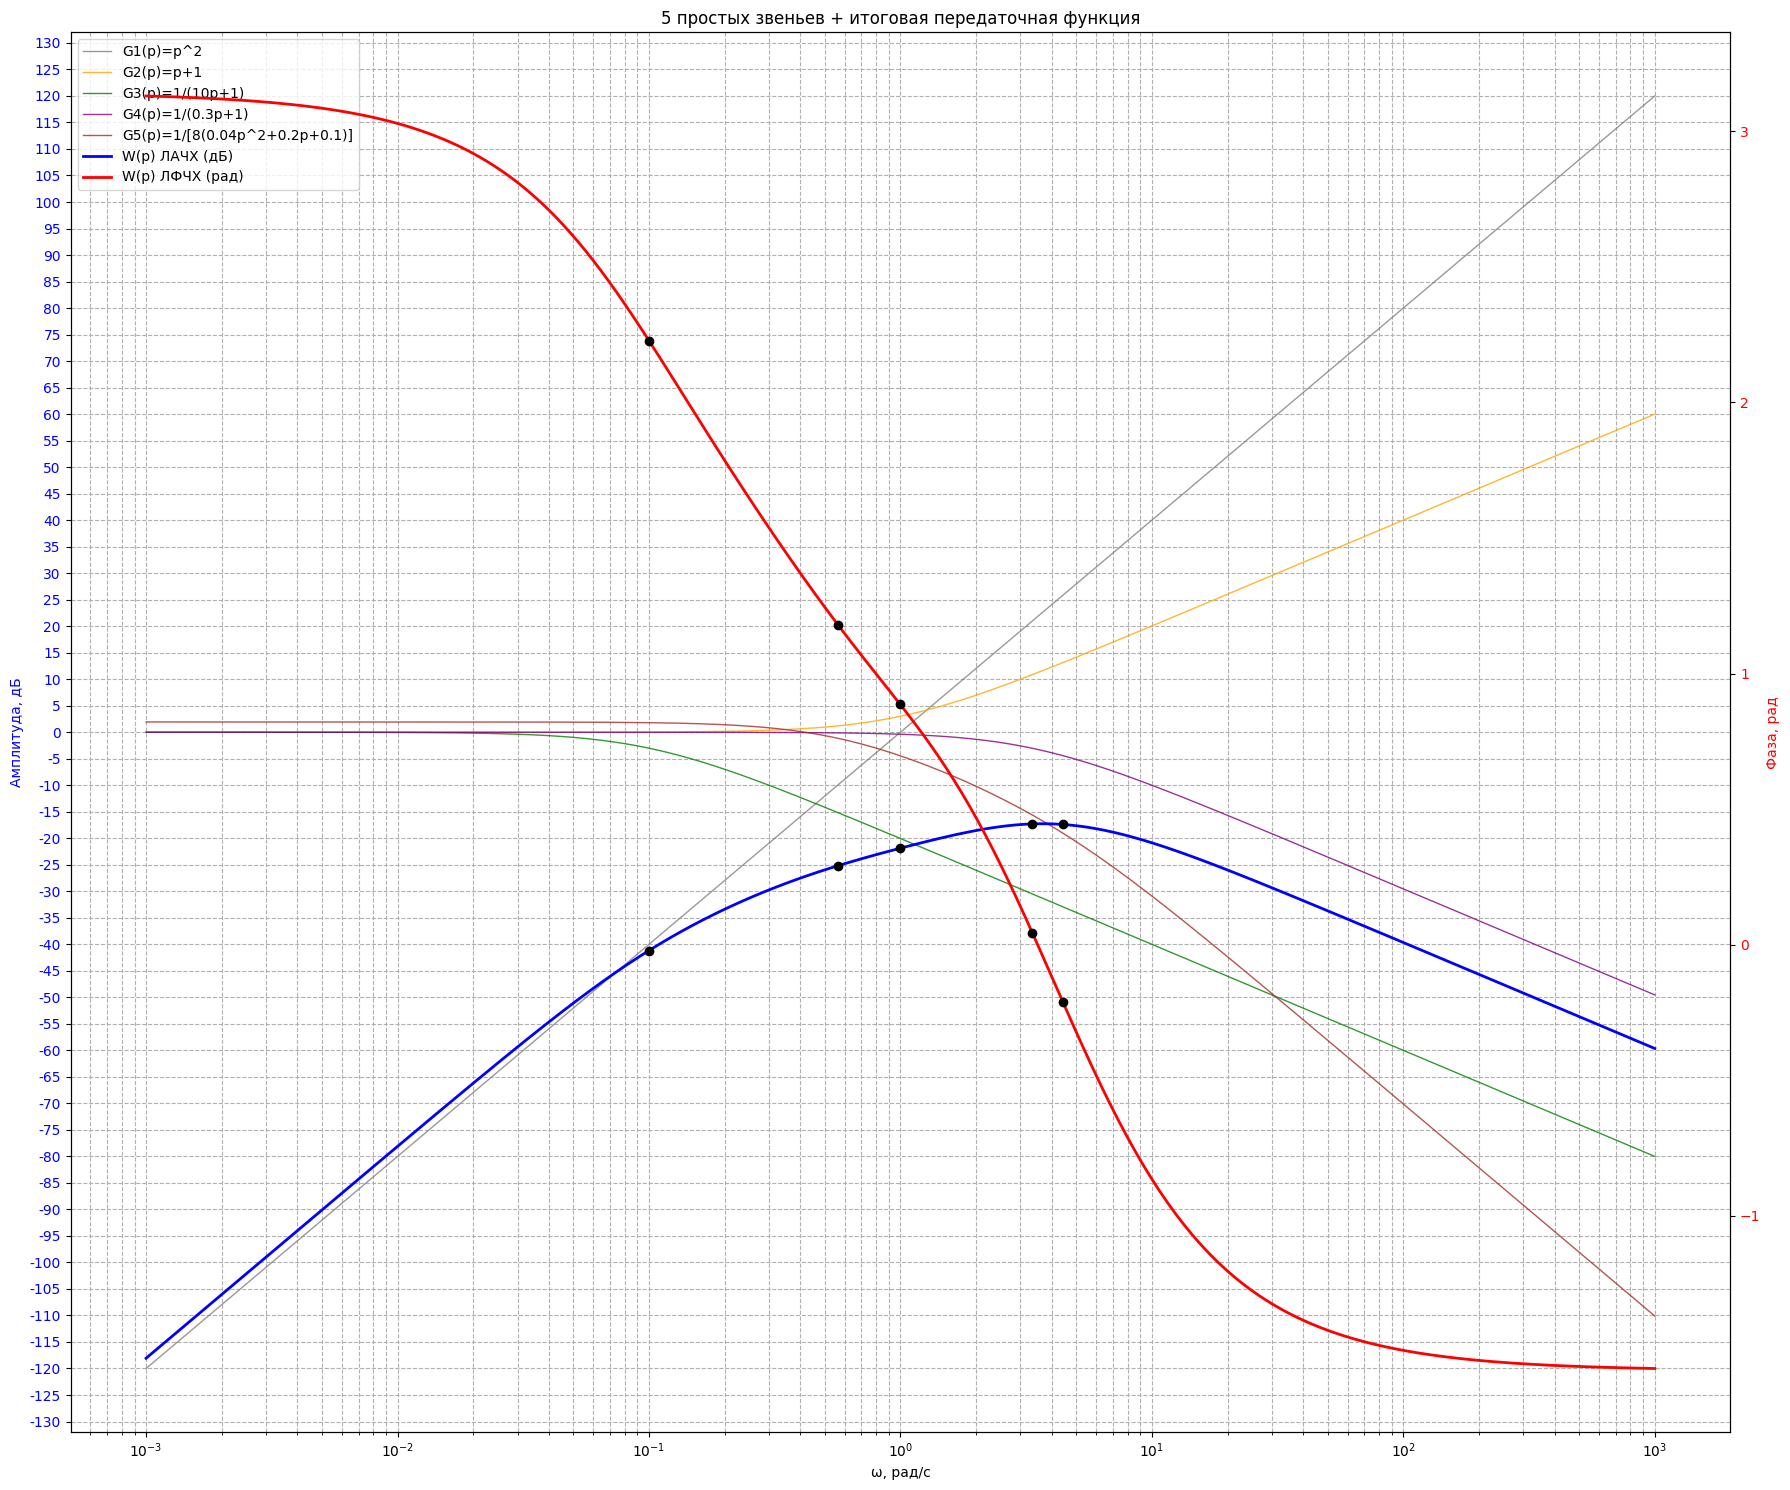

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------
# 1) Исходные данные и задание частотной оси
# -----------------------------------------------------
omega = np.logspace(-3, 3, 1000)  # частоты от 10^-3 до 10^3
jomega = 1j * omega               # p = j*omega

# -----------------------------------------------------
# 2) Пять "простых звеньев"
# -----------------------------------------------------
# Чтобы было ровно 5 звеньев, объединяем константу "1/8"
# вместе со вторым порядком в знаменателе.
G1 = (jomega**2)                                # p^2
G2 = (jomega + 1)                               # (p + 1)
G3 = 1 / (10*jomega + 1)                        # 1/(10p + 1)
G4 = 1 / (0.3*jomega + 1)                       # 1/(0.3p + 1)
G5 = 1 / (8 * (0.04*jomega**2 + 0.2*jomega + 0.1))  # 1/[8(0.04p^2 + 0.2p + 0.1)]

# -----------------------------------------------------
# 3) Суммарная передаточная функция = G1 * G2 * G3 * G4 * G5
# -----------------------------------------------------
W = G1 * G2 * G3 * G4 * G5

# -----------------------------------------------------
# 4) ЛАЧХ (в дБ) и ЛФЧХ (рад) для КАЖДОГО звена и для суммы
# -----------------------------------------------------
partial_mags_db   = []
partial_phases_rad= []

for G in [G1, G2, G3, G4, G5]:
    mag_dB  = 20 * np.log10(np.abs(G))
    phase   = np.angle(G)
    phase   = np.unwrap(phase)   # Чтобы отдельно увидеть «гладкую» фазу каждого звена
    partial_mags_db.append(mag_dB)
    partial_phases_rad.append(phase)

# Суммарный модуль и фаза
W_mag_dB    = 20 * np.log10(np.abs(W))
W_phase_rad = np.unwrap(np.angle(W))

# -----------------------------------------------------
# 5) Поиск точек перелома (угловых частот)
# -----------------------------------------------------
#  - (10p+1) даёт p = -1/10 => omega = 0.1
#  - (0.3p+1) => p = -1/0.3 => omega ~ 3.3333
#  - (p+1) => p = -1 => omega = 1
#  - (0.04p^2 + 0.2p + 0.1) => решим через np.roots:
poly_coefs = [0.04, 0.2, 0.1]
roots = np.roots(poly_coefs)  # обычно два корня
# Из них берем отрицательные (реальные) и берем их по модулю как угловую частоту
poles_2ord = [abs(r) for r in roots if np.isreal(r) and r < 0]

# Собираем
break_freqs = [0.1, 1, 1/0.3] + poles_2ord
break_freqs = sorted(break_freqs)

# -----------------------------------------------------
# 6) Построение графика
# -----------------------------------------------------
fig, ax1 = plt.subplots(figsize=(18, 15))
ax1.set_xscale('log')

# --- 6.1) Графики 5 частичных звеньев (тонкой линией) ---
# Амплитуда (дБ) на ax1, фаза на ax2
colors = ['gray', 'orange', 'green', 'purple', 'brown']  # для примера
labels = ['G1(p)=p^2',
          'G2(p)=p+1',
          'G3(p)=1/(10p+1)',
          'G4(p)=1/(0.3p+1)',
          'G5(p)=1/[8(0.04p^2+0.2p+0.1)]']

for i, (mag_db, ph, col, lab) in enumerate(zip(partial_mags_db,
                                              partial_phases_rad,
                                              colors,
                                              labels)):
    ax1.plot(omega, mag_db, color=col, lw=1, alpha=0.8,
             label=lab)

# Создаем вторую ось для фазы
ax2 = ax1.twinx()

# for i, (mag_db, ph, col, lab) in enumerate(zip(partial_mags_db,
#                                               partial_phases_rad,
#                                               colors,
#                                               labels)):
#     ax2.plot(omega, ph, color=col, lw=1, alpha=0.8,
#              label=lab + ' (фаза)')

# --- 6.2) График суммарной передаточной функции (толще, синяя и красная) ---
# Чтобы легенды не путались, сделаем отдельные вызовы
line_mag, = ax1.plot(omega, W_mag_dB, 'b', lw=2, label='W(p) ЛАЧХ (дБ)')
line_ph,  = ax2.plot(omega, W_phase_rad, 'r', lw=2, label='W(p) ЛФЧХ (рад)')

# Оформление осей
ax1.set_xlabel('ω, рад/с')
ax1.set_ylabel('Амплитуда, дБ', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, which='both', ls='--')
ax2.set_ylabel('Фаза, рад', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# -----------------------------------------------------
# 7) Отметим «точки перелома» чёрными точками и выведем в консоль
# -----------------------------------------------------
print("Точки перелома (в порядке возрастания):")
for bf in break_freqs:
    # Индекс в массиве omega, ближайший к bf
    idx = np.argmin(np.abs(omega - bf))
    # ЛАЧХ и фаза в этой точке
    mag_val   = W_mag_dB[idx]
    phase_val = W_phase_rad[idx]
    print(f"  ω = {bf:.4g},  |W| (дБ) = {mag_val:.3f},  фаза (рад) = {phase_val:.3f}")

    # Добавляем «маркер» на оба графика
    ax1.plot(bf, mag_val, 'ko')
    ax2.plot(bf, phase_val, 'ko')

# -----------------------------------------------------
# 8) Легенда и отображение
# -----------------------------------------------------
# Собираем легенду из обеих осей (ax1 + ax2)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
major_locator = MultipleLocator(5)
ax1.yaxis.set_major_locator(major_locator)

# При желании можно настроить формат (например, чтобы печатать '%.1f дБ')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('5 простых звеньев + итоговая передаточная функция')
plt.tight_layout()
plt.show()
